# Data collection and cleaning

In this notebook we first compile the CPI data and read in the 'melted_merged_allcolumns_v2.csv' dataset.  We then create a dataframe that shows all the nulls per feature per year.  With this information the data is cleaned to include no nulls.  Correlation heatmaps are then used to reduce feature count.  Finally LinearRegression is used to calculate coefficients to determine the weight that each feature has.

In [245]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

### Compile CPI data

Combine all the individual CPI datasets for years 1995-2011.  Second, format the 2012_2022_cpi.csv dataset to the same format then combine both dataframes and save as cpi.csv.

In [246]:
# Read in and combine corruption perception index 1995 - 2011

cpi_1 = pd.DataFrame()

for i in range(1995, 2012, 1):
    cpi_temp = pd.read_csv(f'../datasets/datasets_cpi/{i}_cpi.csv')
    cpi_temp = cpi_temp.loc[:, ['country', 'iso', 'score']]
    cpi_temp['year'] = i
    cpi_temp['score'] = cpi_temp['score'] * 10  # Multiply scores by 10 to get CPI on same scale as 2012-2022 data
    cpi_1 = pd.concat([cpi_1, cpi_temp], ignore_index = True)
    
cpi_1 = cpi_1[['country', 'iso', 'year', 'score']]

In [247]:
cpi_1.head()

,country,iso,year,score
0,New Zealand,NZL,1995,95.5
1,Denmark,DNK,1995,93.2
2,Singapore,SGP,1995,92.6
3,Finland,FIN,1995,91.2
4,Canada,CAN,1995,88.7


In [248]:
# Read in 2012_2022_cpi.csv and extract only the necessary data

cpi_2 = pd.DataFrame()

cpi = pd.read_csv('../datasets/datasets_cpi/2012_2022_cpi.csv')
cpi_cols = cpi[[col for col in cpi.columns if 'CPI' in col]]
cpi_2[['country', 'iso']] = cpi.iloc[:,:2]
cpi_2 = pd.concat([cpi_2, cpi_cols], axis = 1)
cpi_2

,country,iso,CPI score 2022,CPI score 2021,CPI score 2020,CPI score 2019,CPI score 2018,CPI score 2017,CPI score 2016,CPI score 2015,CPI score 2014,CPI Score 2013,CPI Score 2012
0,Afghanistan,AFG,24.0,16.0,19.0,16.0,16.0,15.0,15.0,11.0,12.0,8.0,8.0
1,Albania,ALB,36.0,35.0,36.0,35.0,36.0,38.0,39.0,36.0,33.0,31.0,33.0
2,United Arab Emirates,ARE,67.0,69.0,71.0,71.0,70.0,71.0,66.0,70.0,70.0,69.0,68.0
3,Angola,AGO,33.0,29.0,27.0,26.0,19.0,19.0,18.0,15.0,19.0,23.0,22.0
4,Argentina,ARG,38.0,38.0,42.0,45.0,40.0,39.0,36.0,32.0,34.0,34.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Venezuela,VEN,14.0,14.0,15.0,16.0,18.0,18.0,17.0,17.0,19.0,20.0,19.0
177,Vietnam,VNM,42.0,39.0,36.0,37.0,33.0,35.0,33.0,31.0,31.0,31.0,31.0
178,Syria,SYR,13.0,13.0,14.0,13.0,13.0,14.0,13.0,18.0,20.0,17.0,26.0
179,Zambia,ZMB,33.0,33.0,33.0,34.0,35.0,37.0,38.0,38.0,38.0,38.0,37.0


In [249]:
# Format 2012-2022 data to match 1995-2011 data

cpi_3 = pd.DataFrame()

j = 12

for i in range(2012, 2023, 1):
    cpi_temp = cpi_2.iloc[:, :2]
    cpi_temp['year'] = i
    cpi_temp['score'] = cpi_2.iloc[:, j]
    cpi_3 = pd.concat([cpi_3, cpi_temp], ignore_index = True)
    j -= 1
cpi_3.head()

,country,iso,year,score
0,Afghanistan,AFG,2012,8.0
1,Albania,ALB,2012,33.0
2,United Arab Emirates,ARE,2012,68.0
3,Angola,AGO,2012,22.0
4,Argentina,ARG,2012,35.0


In [250]:
# Combine cpi data and save as cpi.csv

df_cpi = pd.concat([cpi_1, cpi_3], ignore_index = True)
df_cpi.to_csv('../datasets/datasets_cpi/cpi.csv')
df_cpi

,country,iso,year,score
0,New Zealand,NZL,1995,95.5
1,Denmark,DNK,1995,93.2
2,Singapore,SGP,1995,92.6
3,Finland,FIN,1995,91.2
4,Canada,CAN,1995,88.7
...,...,...,...,...
4102,Venezuela,VEN,2022,14.0
4103,Vietnam,VNM,2022,42.0
4104,Syria,SYR,2022,13.0
4105,Zambia,ZMB,2022,33.0


In [251]:
# Find nulls per column

df_cpi.isnull().sum()

country     0
iso         0
year        0
score      42
dtype: int64

In [252]:
# Get info for CPI dataframe

df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4107 entries, 0 to 4106
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  4107 non-null   object 
 1   iso      4107 non-null   object 
 2   year     4107 non-null   int64  
 3   score    4065 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.5+ KB


### Data Cleaning

Read in melted_merged_allcolumns_v2.csv and find all nulls per feature per year.  Using this information, drop rows and reduce date range to create a clean no_null dataset.

In [253]:
# Read in full dataset after melting and merging all feature data

df = pd.read_csv('../datasets/melted_merged_allcolumns_v2.csv')

<ipython-input-253-3dd4224c7e4f>:3: DtypeWarning: Columns (4,7,11,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../datasets/melted_merged_allcolumns_v2.csv')


In [254]:
# Start cleaning data 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74742 entries, 0 to 74741
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country                           70316 non-null  object 
 1   iso                               74742 non-null  object 
 2   year                              74742 non-null  int64  
 3   CPI                               4068 non-null   float64
 4   trade_balance_perc_of_gdp         8730 non-null   object 
 5   life_expectancy                   56646 non-null  float64
 6   journos_imprisoned_yearly         7590 non-null   float64
 7   inflation_annual_perc             10047 non-null  object 
 8   gini_index                        49477 non-null  float64
 9   democracy_index                   2520 non-null   float64
 10  childmor_0_5_per_1000             57527 non-null  float64
 11  cellphone_per_100                 10246 non-null  object 
 12  avrg

In [255]:
# All feature columns should be numeric.  Convert object typ columns to float64

columns_type = ['trade_balance_perc_of_gdp', 'inflation_annual_perc' , 'cellphone_per_100', 'linguistic_div_index', 'religious_div_index']
for col in columns_type:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [256]:
# Scores of 100 were prior to 2012...scores were 1-10 so we multiplied scores by 10 to get on same scale as 2012 and later years

df[df['CPI'] == 100]

,country,iso,year,CPI,trade_balance_perc_of_gdp,life_expectancy,journos_imprisoned_yearly,inflation_annual_perc,gini_index,democracy_index,...,alcohol_consumption,unemployment_perc_tot_labor,pop_percent_with_sanitation,undernourishment_prevalence_perc,population,literacy,gdp_per_capita_2017dollar,fertility_rate,extreme_poverty,electricity_access
163,Denmark,DNK,1998,100.0,3.07,76.7,84.5,1.23,23.4,NaN,...,NaN,5.04,NaN,NaN,5298991.0,NaN,46096.370,1.72,NaN,100.0
252,Denmark,DNK,1999,100.0,6.00,76.7,84.3,1.68,23.6,NaN,...,NaN,5.14,NaN,NaN,5319856.0,NaN,47298.540,1.74,NaN,100.0
359,Finland,FIN,2000,100.0,9.17,78.0,83.2,1.64,27.2,NaN,...,10.00369,11.13,99.44823,NaN,5176208.0,100.0,39894.195,1.73,0.0,100.0


In [257]:
# drop all rows that do not have a CPI value as they will not be used for training

df = df.dropna(subset = 'CPI', ignore_index = True)

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country                           4052 non-null   object 
 1   iso                               4068 non-null   object 
 2   year                              4068 non-null   int64  
 3   CPI                               4068 non-null   float64
 4   trade_balance_perc_of_gdp         3688 non-null   float64
 5   life_expectancy                   4039 non-null   float64
 6   journos_imprisoned_yearly         3717 non-null   float64
 7   inflation_annual_perc             3959 non-null   float64
 8   gini_index                        4042 non-null   float64
 9   democracy_index                   2454 non-null   float64
 10  childmor_0_5_per_1000             4042 non-null   float64
 11  cellphone_per_100                 3973 non-null   float64
 12  avrg_d

In [259]:
# Create dataframe of null count by feature per year to aid in feature selection null resolution

df_null = pd.DataFrame(columns = ['year', 'null_count', 'feature'])
cols = df.columns[4:]
i = 0

for year in range(1995, 2023, 1):
    for col in cols:
        df_null.loc[i, 'year'] = year
        df_null.loc[i,'null_count'] = df.loc[df['year'] == year, col].isnull().sum()
        df_null.loc[i,'feature'] = col
        i += 1

In [260]:
df_null

,year,null_count,feature
0,1995,1,trade_balance_perc_of_gdp
1,1995,0,life_expectancy
2,1995,1,journos_imprisoned_yearly
3,1995,1,inflation_annual_perc
4,1995,0,gini_index
...,...,...,...
947,2022,136,literacy
948,2022,180,gdp_per_capita_2017dollar
949,2022,4,fertility_rate
950,2022,180,extreme_poverty


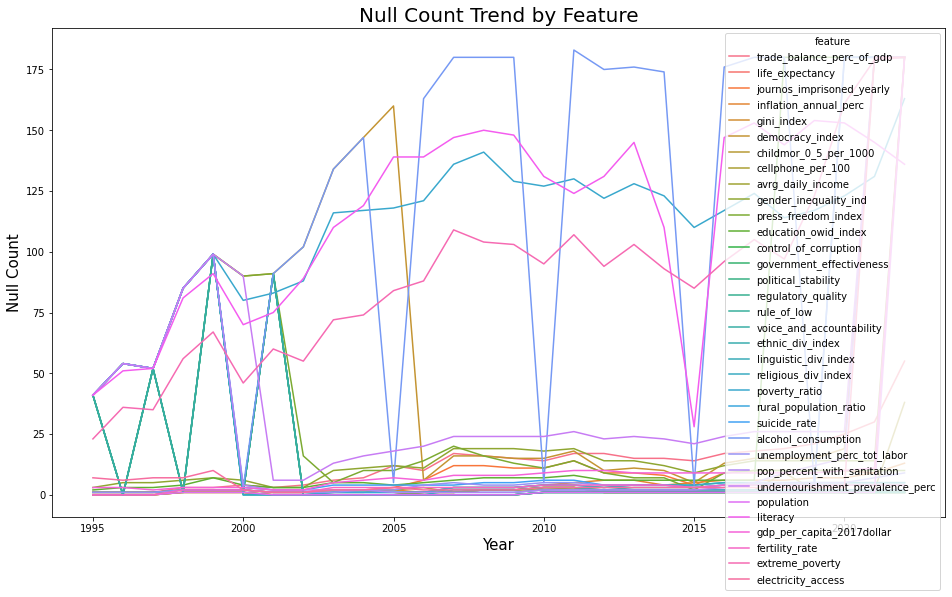

In [261]:
# Plot null count trend by feature to identify features with high null count and the best date range to use

plt.figure(figsize = (16, 9))
sns.lineplot(data = df_null,
             x = 'year', 
             y = 'null_count', 
             hue = 'feature')
plt.title('Null Count Trend by Feature', size = 20)
plt.xlabel('Year', size = 15)
plt.ylabel('Null Count', size = 15);
plt.savefig('../images/01_null_count_trend_1')

**Observation:** four features have high null count throughout entire dataset.  Drop these features to better identify next cleaning steps.

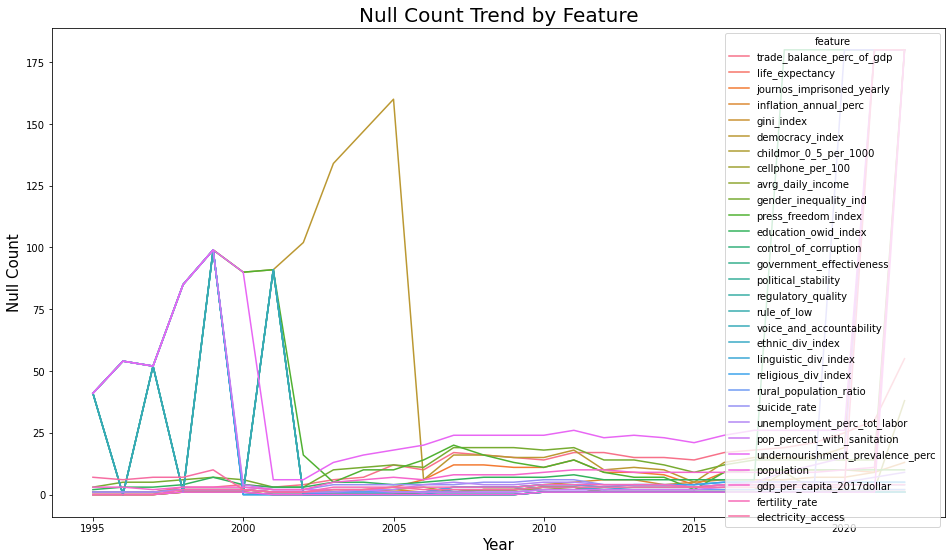

In [197]:
# Drop columns 'literacy', 'alcohol_consumption', 'poverty_ratio', 'extreme_poverty'

df_null = pd.DataFrame(columns = ['year', 'null_count', 'feature'])
df.drop(columns = ['literacy', 'alcohol_consumption', 'poverty_ratio', 'extreme_poverty'], inplace = True)
cols = df.columns[4:]

i = 0

for year in range(1995, 2023, 1):
    for col in cols:
        df_null.loc[i, 'year'] = year
        df_null.loc[i,'null_count'] = df.loc[df['year'] == year, col].isnull().sum()
        df_null.loc[i,'feature'] = col
        i += 1

plt.figure(figsize = (16, 9))
sns.lineplot(data = df_null,
             x = 'year', 
             y = 'null_count', 
             hue = 'feature')
plt.title('Null Count Trend by Feature', size = 20)
plt.xlabel('Year', size = 15)
plt.ylabel('Null Count', size = 15);
plt.savefig('../images/null_count_trend')

**Observation:**  There are several features whose data cleans up after 2002-2006.   

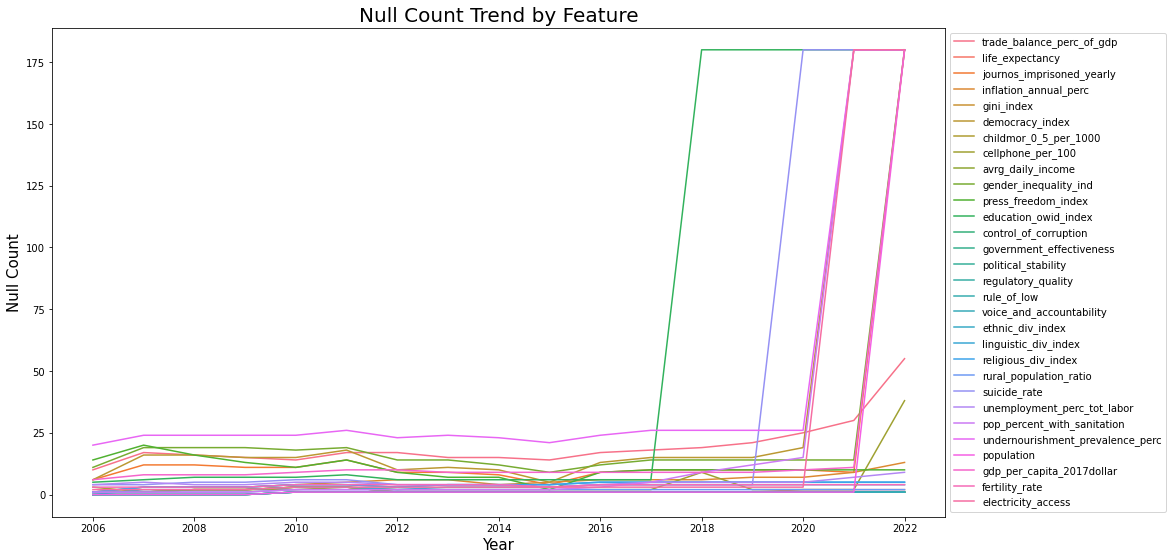

In [198]:
# Drop data prior to 2006

df_null = pd.DataFrame(columns = ['year', 'null_count', 'feature'])
cols = df.columns[4:]

i = 0

for year in range(2006, 2023, 1):
    for col in cols:
        df_null.loc[i, 'year'] = year
        df_null.loc[i,'null_count'] = df.loc[df['year'] == year, col].isnull().sum()
        df_null.loc[i,'feature'] = col
        i += 1

plt.figure(figsize = (16, 9))
ax = sns.lineplot(data = df_null,
             x = 'year', 
             y = 'null_count', 
             hue = 'feature')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Null Count Trend by Feature', size = 20)
plt.xlabel('Year', size = 15)
plt.ylabel('Null Count', size = 15);
plt.savefig('../images/null_count_trend')

In [199]:
# Find feature/year that has high null count

df_null.groupby(['year', 'feature'])['null_count'].max().sort_values(ascending = False).head(30)

year  feature                         
2022  gender_inequality_ind               180
      journos_imprisoned_yearly           180
      democracy_index                     180
2021  democracy_index                     180
2022  pop_percent_with_sanitation         180
      population                          180
2020  suicide_rate                        180
2022  gdp_per_capita_2017dollar           180
2020  education_owid_index                180
2022  electricity_access                  180
2021  education_owid_index                180
      electricity_access                  180
2022  suicide_rate                        180
2018  education_owid_index                180
2021  undernourishment_prevalence_perc    180
2019  education_owid_index                180
2021  pop_percent_with_sanitation         180
      suicide_rate                        180
2022  undernourishment_prevalence_perc    180
      education_owid_index                180
      trade_balance_perc_of_gdp          

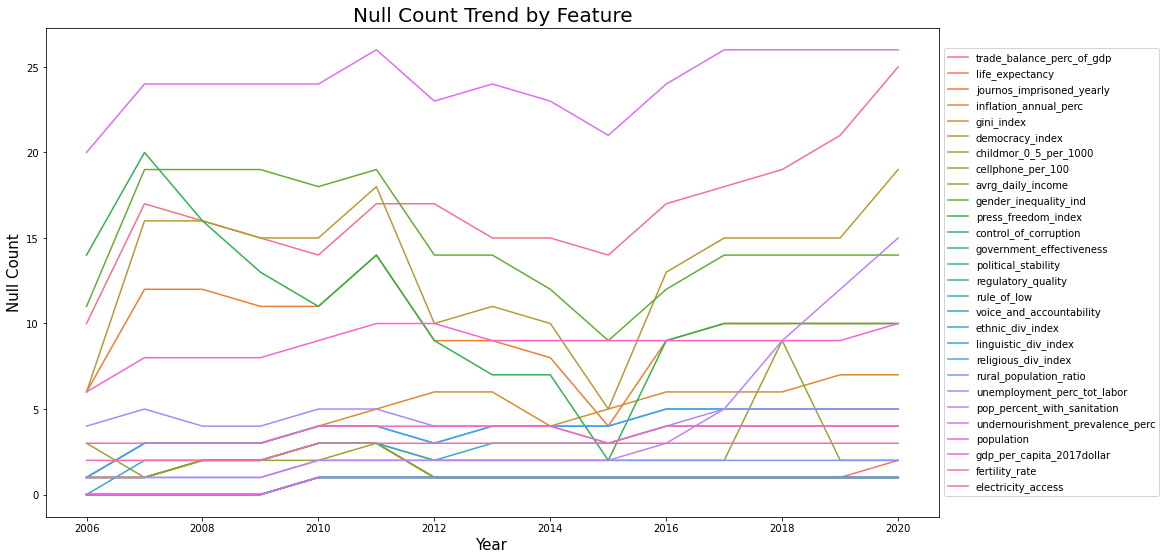

In [200]:
# Drop data after 2020 and columns 'education_owid_index', 'suicide_rate'

df_null = pd.DataFrame(columns = ['year', 'null_count', 'feature'])
df.drop(columns = ['education_owid_index', 'suicide_rate'], inplace = True)
cols = df.columns[4:]

i = 0

for year in range(2006, 2021, 1):
    for col in cols:
        df_null.loc[i, 'year'] = year
        df_null.loc[i,'null_count'] = df.loc[df['year'] == year, col].isnull().sum()
        df_null.loc[i,'feature'] = col
        i += 1

plt.figure(figsize = (16, 9))
ax = sns.lineplot(data = df_null,
             x = 'year', 
             y = 'null_count', 
             hue = 'feature')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Null Count Trend by Feature', size = 20)
plt.xlabel('Year', size = 15)
plt.ylabel('Null Count', size = 15);
plt.savefig('../images/null_count_trend')

In [201]:
# modify dataframe to reflect above charts

df = df.loc[(df['year'] > 2005) & (df['year'] < 2021)]
df.shape

(2653, 32)

In [202]:
# Drop all rows with a null value

df_nonull = df.dropna()
df_nonull.shape

(1859, 32)

In [203]:
# Save no_null dataset

df_nonull.to_csv('../datasets/1860_no_null.csv')

### Create Correlation Heatmaps

Create correlation heatmaps with df_nonull dataset to check collineararity to further reduce feature count.

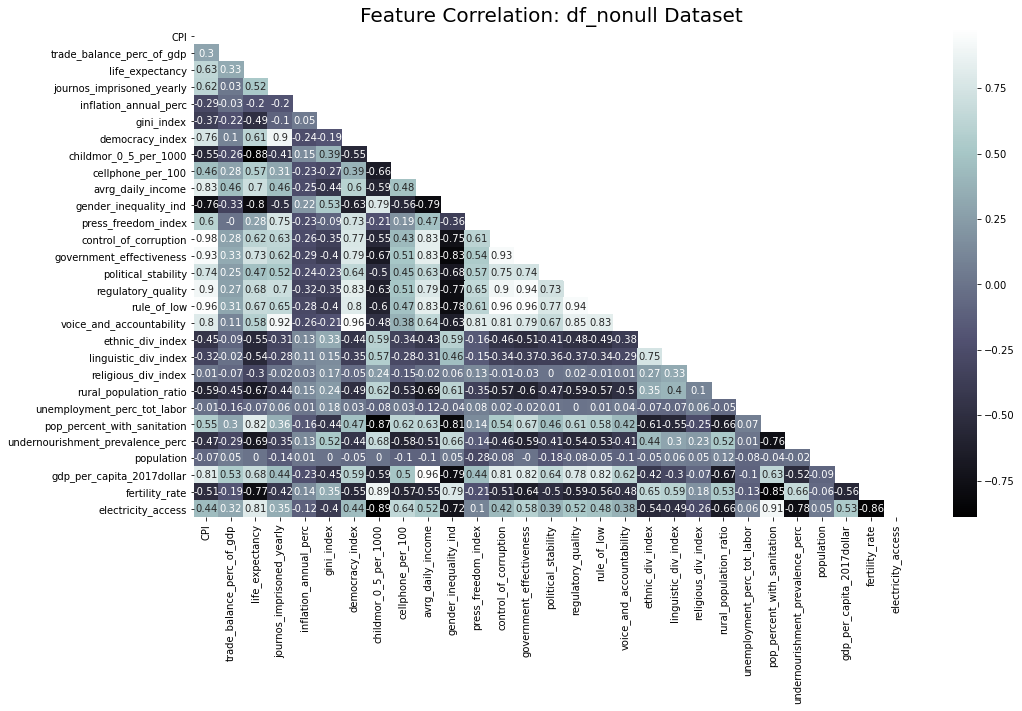

In [204]:
# Create heatmap of all features of df_nonull

df_corr = df_nonull.drop(columns = ['country', 'iso', 'year'])
plt.figure(figsize = (16, 9))
corr = round(df_corr.corr(numeric_only = True), 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
           cmap = 'bone',
           mask = mask,
           annot = True);
plt.title('Feature Correlation: df_nonull Dataset', size = 20);

**Observation:**  Several features show extreme correlation with CPI, 'control_of_corruption','government_effectiveness', 'regulatory_quality', 'rule_of_low', 'voice_and_accountability'.  It is likely these features are calculated with similar data as CPI.  Decision made to drop these features.

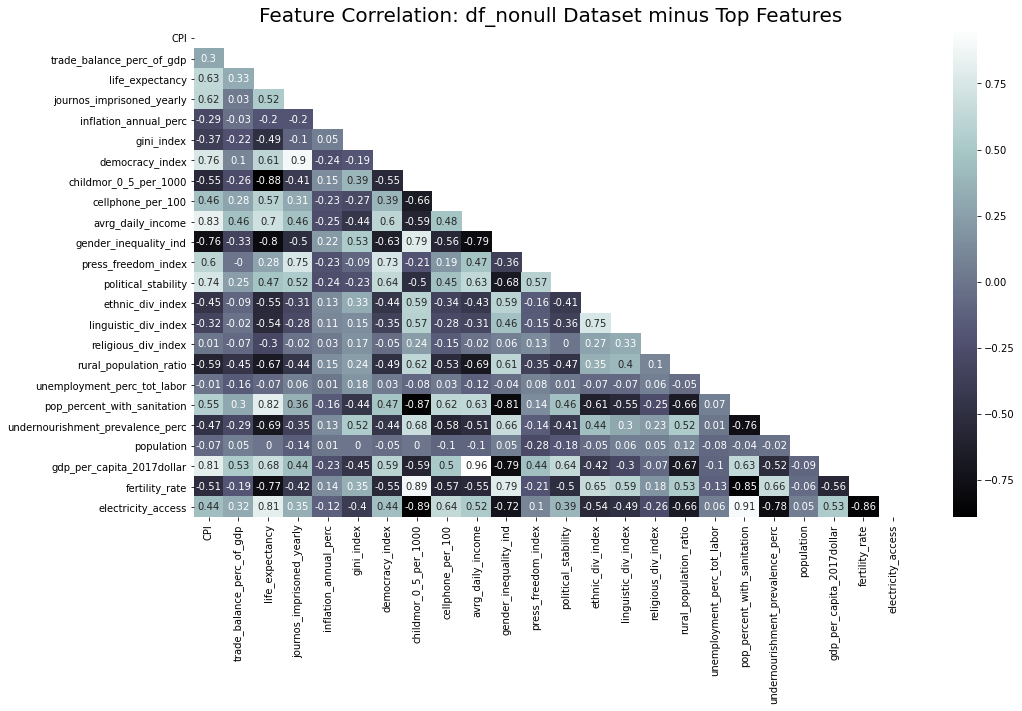

In [205]:
# Create heatmap of df_nonull minus possibly over-correlated top features

df_corr_droptop = df_corr.drop(columns = ['control_of_corruption','government_effectiveness', 
                                          'regulatory_quality', 'rule_of_low', 
                                          'voice_and_accountability'])
plt.figure(figsize = (16, 9))
corr = round(df_corr_droptop.corr(numeric_only = True), 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
           cmap = 'bone',
           mask = mask,
           annot = True);
plt.title('Feature Correlation: df_nonull Dataset minus Top Features', size = 20);

**Observation:**  Several features show extreme correlation with other features, ie. correlation > 0.90. The worse CPI correlated feature of each of these feature pairs will be dropped.

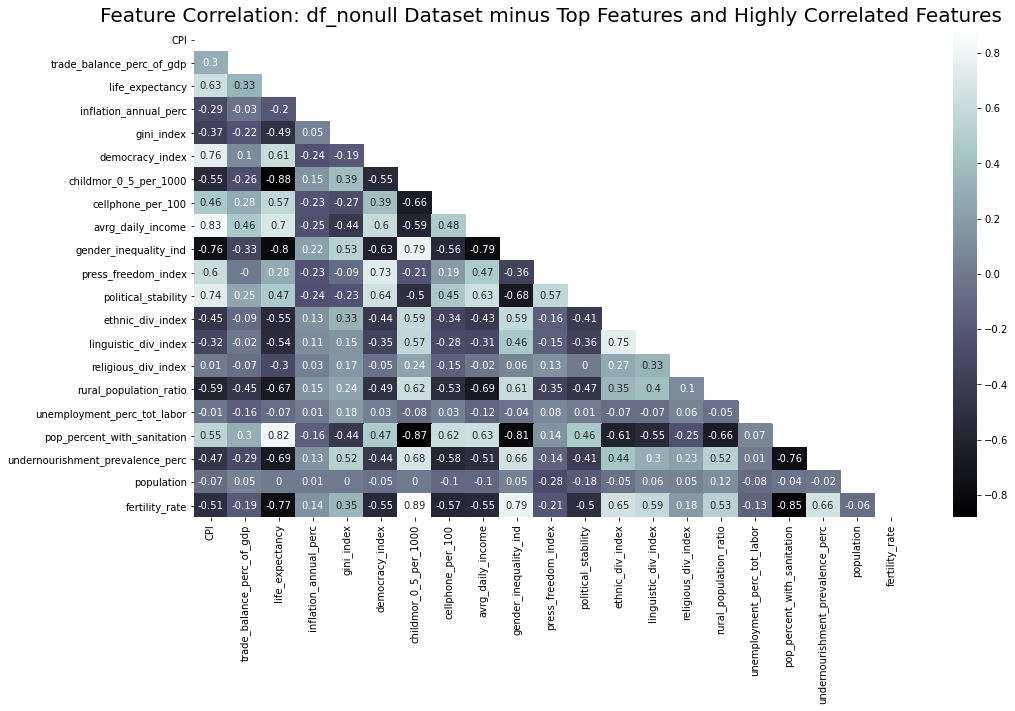

In [206]:
# Create heatmap of df_nonull minus possibly over-correlated top features with CPI and over-correlated features with others (>0.90)

df_corr_droptop_highcorr = df_corr_droptop.drop(columns = ['journos_imprisoned_yearly','gdp_per_capita_2017dollar', 'electricity_access'])
plt.figure(figsize = (16, 9))
corr = round(df_corr_droptop_highcorr.corr(numeric_only = True), 2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
           cmap = 'bone',
           mask = mask,
           annot = True);
plt.title('Feature Correlation: df_nonull Dataset minus Top Features and Highly Correlated Features', size = 20);

### Fit LinearRegression models

Fit LinearRegression models to the three dataframes used to create the previous three heatmaps and compare coefficients and scores.

In [207]:
# Create X and y variables for three lr models

X1 = df_corr.drop(columns = ['CPI'])

X2 = df_corr_droptop.drop(columns = ['CPI'])

X3 = df_corr_droptop_highcorr.drop(columns = ['CPI'])

y = df_nonull['CPI']

In [208]:
# Train test split each dataset

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, random_state = 42)

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state = 42)

X3_train, X3_test, y_train, y_test = train_test_split(X3, y, random_state = 42)

In [209]:
# Scale, fit each model

sc1 = StandardScaler()
X1_train_sc = sc1.fit_transform(X1_train)
X1_test_sc = sc1.transform(X1_test)

sc2 = StandardScaler()
X2_train_sc = sc2.fit_transform(X2_train)
X2_test_sc = sc2.transform(X2_test)

sc3 = StandardScaler()
X3_train_sc = sc3.fit_transform(X3_train)
X3_test_sc = sc3.transform(X3_test)

lr1 = LinearRegression()
lr1.fit(X1_train_sc, y_train)

lr2 = LinearRegression()
lr2.fit(X2_train_sc, y_train)

lr3 = LinearRegression()
lr3.fit(X3_train_sc, y_train)

LinearRegression()

In [210]:
# Calculate train/test R2 scores for each model

print("df_corr")
print(f'Training R2: {round(lr1.score(X1_train_sc, y_train),3)}')
print(f'Testing R2: {round(lr1.score(X1_test_sc, y_test),3)}')
print('='*26)
print("df_corr_droptop")
print(f'Training R2: {round(lr2.score(X2_train_sc, y_train),3)}')
print(f'Testing R2: {round(lr2.score(X2_test_sc, y_test),3)}')
print('='*26)
print("df_corr_droptop_highcorr")
print(f'Training R2: {round(lr3.score(X3_train_sc, y_train),3)}')
print(f'Testing R2: {round(lr3.score(X3_test_sc, y_test),3)}')

df_corr
Training R2: 0.972
Testing R2: 0.969
df_corr_droptop
Training R2: 0.848
Testing R2: 0.84
df_corr_droptop_highcorr
Training R2: 0.845
Testing R2: 0.835


**Observation:**  The first dataset with all the features seems to be too accurate for this dataset and a simple LinearRegression model.  The second two models seem to be more inline with reality.  Decision made to use df_corr_droptop_highcorr dataset as it has a realitively good score and is best with regards to feature correlation.

In [211]:
# Create dataframe of coefficients

df_1 = pd.DataFrame(lr1.coef_, index = X1.columns, columns = ['df_corr'])
df_2 = pd.DataFrame(lr2.coef_, index = X2.columns, columns = ['df_corr_droptop'])
df_3 = pd.DataFrame(lr3.coef_, index = X3.columns, columns = ['df_corr_droptop_highcorr'])

coef_df = pd.concat([df_1, df_2, df_3], axis = 1, join = 'outer')
coef_df.round(3).sort_values(by = 'df_corr_droptop_highcorr', ascending = False)

,df_corr,df_corr_droptop,df_corr_droptop_highcorr
avrg_daily_income,-0.249,7.475,9.801
democracy_index,0.077,8.382,7.302
fertility_rate,0.668,4.493,5.509
political_stability,-0.606,3.949,4.221
pop_percent_with_sanitation,-0.362,3.038,1.624
unemployment_perc_tot_labor,-0.456,1.125,1.228
population,-0.001,1.239,1.191
cellphone_per_100,1.106,0.756,0.711
religious_div_index,0.533,0.727,0.628
undernourishment_prevalence_perc,0.885,-0.137,0.460


**Observation:**  Comparison of feature coefficients between datasets confirms previous assumpumptions that some features were overly correlated with CPI, ie. 17.45 coefficient for control_of_corruption.

### Check LINEM Assumptions

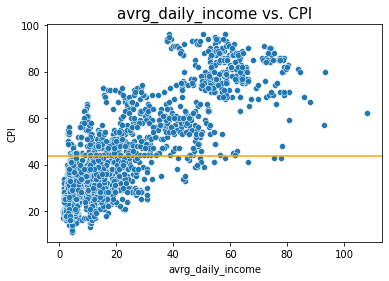

In [212]:
# Check Linearity:  check linearity of 3 most CPI correlated features with base model in orange

sns.scatterplot(x = "avrg_daily_income",
                y = "CPI",
                data = df_corr_droptop_highcorr)
plt.title('avrg_daily_income vs. CPI', size = 15)
plt.xlabel('avrg_daily_income', size = 10)
plt.ylabel('CPI', size = 10)

plt.axhline(y = (df_corr_droptop_highcorr['CPI'].mean()), color = 'orange');

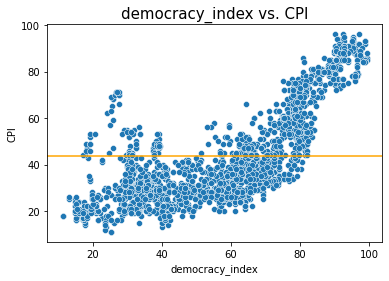

In [213]:
sns.scatterplot(x = "democracy_index",
                y = "CPI",
                data = df_corr_droptop_highcorr)
plt.title('democracy_index vs. CPI', size = 15)
plt.xlabel('democracy_index', size = 10)
plt.ylabel('CPI', size = 10)

plt.axhline(y = (df_corr_droptop_highcorr['CPI'].mean()), color = 'orange');

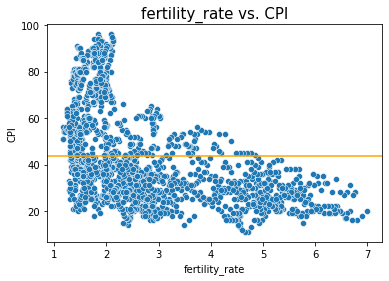

In [214]:
sns.scatterplot(x = "fertility_rate",
                y = "CPI",
                data = df_corr_droptop_highcorr)
plt.title('fertility_rate vs. CPI', size = 15)
plt.xlabel('fertility_rate', size = 10)
plt.ylabel('CPI', size = 10)

plt.axhline(y = (df_corr_droptop_highcorr['CPI'].mean()), color = 'orange');

**Observation:** Positive linearity holds for avg_daily_income and democracy index.   Fertility has a negative linearity relationship with CPI, highest CPI have a fertily rate 1-2. Null model, average CPI for dataset, is overlayed in orange and can be seen to not accurately predict CPI.

In [215]:
# Check Independence

**Observation:** Independent observations are assumed

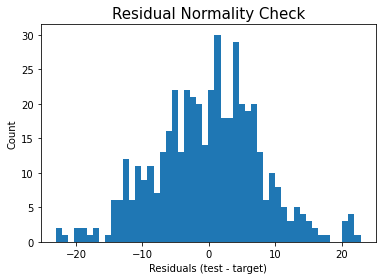

In [216]:
# Check normality of errors

preds_lr3 = lr3.predict(X3_test_sc)
resids = y_test - preds_lr3

plt.hist(resids, bins = 50)
plt.title('Residual Normality Check', size = 15)
plt.xlabel('Residuals (test - target)', size = 10)
plt.ylabel('Count', size = 10);

**Observation:** Residual normality is good overall with a some outliers on both sides of the spectrum

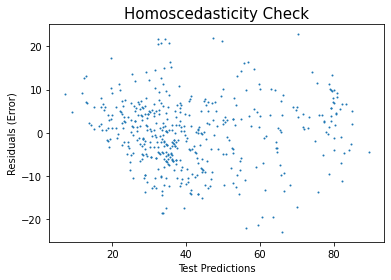

In [217]:
# Check for equal variance of errors

plt.scatter(preds_lr3, resids, s = 1)
plt.title('Homoscedasticity Check', size = 15)
plt.xlabel('Test Predictions', size = 10)
plt.ylabel('Residuals (Error)', size = 10);

**Observation:** Desired error randomness

In [218]:
# Check for no multicollinearity

**Observation:** See previous heatmap titled 'Feature Correlation: df_nonull Dataset minus Top Features and Highly Correlated Features'

In [219]:
# Save production dataset

df_corr_droptop_highcorr.to_csv('../datasets/df_corr_droptop_highcorr.csv')

## Key Takeaways

Given the large number of different datasets there were a lot of nulls to reconcile after all the data was compiled.  The null trend charts helped immensely in identifying which features to use and what time frames are best.  A systematic approch to fixing nulls and reducing collinearity resulted in a linear regression model with interpretable coefficients and a test R2 score of 0.835.  The three most heavily weighted features were avrg_daily_income, democracy_index, fertility_rate.